In [ ]:
!git clone https://github.com/Nadim0403/Data_DL.git

Cloning into 'Data_DL'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), 1.04 MiB | 7.38 MiB/s, done.


In [ ]:
%matplotlib inline


Tools for ploting

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

And load images

torch.Size([3, 600, 600])


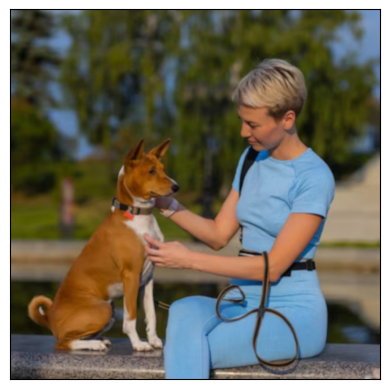

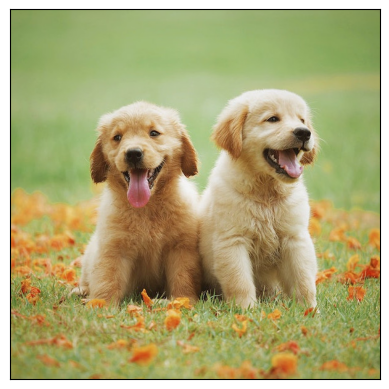

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

dog1_int = read_image('Data_DL/data/dogs/dog_4.jpg')
dog2_int = read_image('Data_DL/data/dogs/ns8230-image.jpg')
image_list = [dog1_int, dog2_int]

# What is the dimension of this tensor?
print(dog1_int.shape)

show(dog1_int)
show(dog2_int)

## Bounding boxes detection
A bounding box is a rectangle that specifies an object position, its class (e.g., a person or a dog) and confidence(how likely it is to be at that location). Bounding boxes are mainly used in the task of object detection, where the aim is identifying the position and type of multiple objects in the image.

We can use the function [draw_bounding_boxes](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html) to draw bounding boxes on an image.



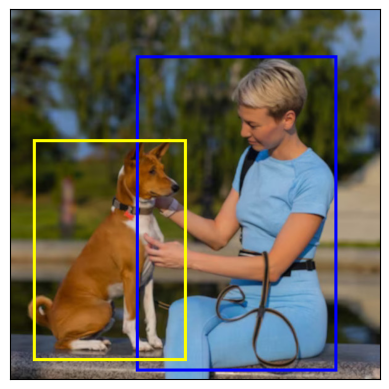

In [ ]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[204, 75, 530, 587], [37, 211, 286, 570]], dtype=torch.float) # format is (xmin, ymin, xmax, ymax)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

Now, using a trained CNN model (here we are using [torchvision.models.detection.fasterrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)) to predict the bounding boxes.



In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

inputs = [transforms(d) for d in image_list] # why do we need to transform the images? What is happening during the transformation?

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False) # why do we need to load the weights?
model = model.eval() # what does this do?

outputs = model(inputs)

# What is the shape of the inputs tensors?
print(inputs[0].shape)

# What is the range of the inputs (max/min values)?
print(inputs[0].min(), inputs[0].max())

# What are the outputs predictions and how are they packed?
#print(outputs)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


torch.Size([3, 600, 600])
tensor(0.) tensor(0.9451)


Let's plot the boxes detected by our model. We will only plot the boxes with a
score greater than a given threshold.



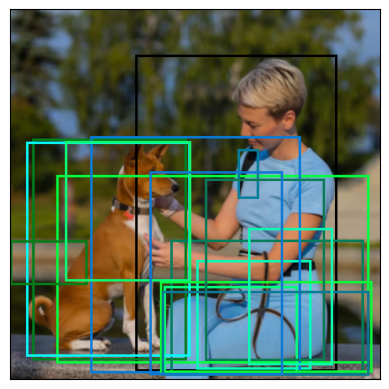

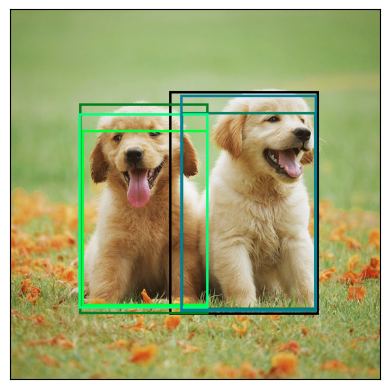

In [ ]:
# plot the predicted bounding boxes (hint, you can use enumerate)
for count, image in enumerate(image_list):
    boxes = outputs[count]['boxes']
    show(draw_bounding_boxes(image, boxes, width=4))

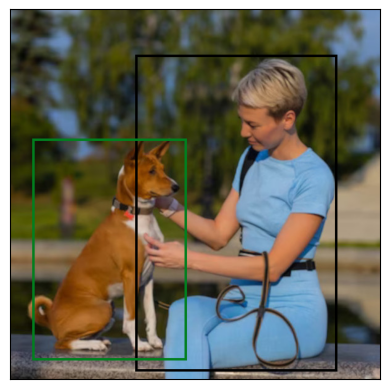

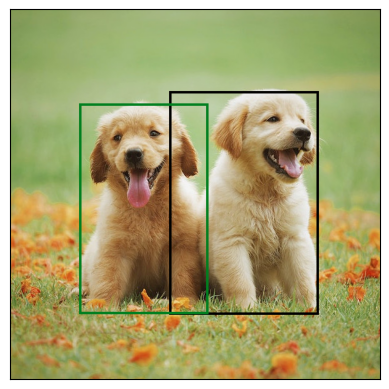

In [ ]:
# Use a threshold for filtering the predictions
score_threshold = .8
for count, image in enumerate(image_list):
    boxes = outputs[count]['boxes'][outputs[count]['scores'] > score_threshold]
    show(draw_bounding_boxes(image, boxes, width=4))

## Semantic segmentation

Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image. It is used to recognize a collection of pixels that form distinct categories. For example, an autonomous vehicle needs to identify vehicles, pedestrians, traffic signs, pavement, and other road features.

The [torchvision.utils.draw_segmentation_masks](https://pytorch.org/vision/main/generated/torchvision.utils.draw_segmentation_masks.html) function can be used to plots those masks on top of the original image. This function expects the masks to be boolean masks, but our masks above contain probabilities in ``[0, 1]``. To get boolean masks, we can do the following:

shape of the manual_annotation_dog: torch.Size([4, 600, 600])
min and max of the manual annotation: min=0, max=255
shape of the annotations: torch.Size([2, 600, 600])


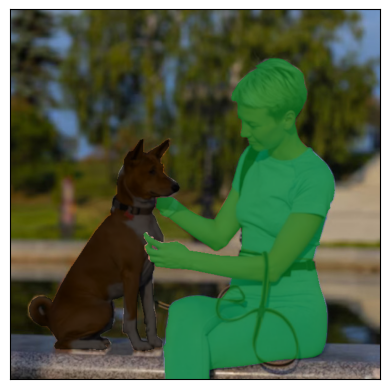

In [ ]:
from torchvision.utils import draw_segmentation_masks

# load the manual annotations
manual_annotation_dog = read_image('Data_DL/data/dogs/dog_4_annotation_dog.png')
manual_annotation_human = read_image('Data_DL/data/dogs/dog_4_annotation_human.png')
print (f"shape of the manual_annotation_dog: {manual_annotation_dog.shape}")
print (f"min and max of the manual annotation: min={manual_annotation_dog.min()}, max={manual_annotation_dog.max()}")

# show the annotations
annotations = torch.cat(((manual_annotation_dog[1]>125).unsqueeze(0), (manual_annotation_human[1]>125).unsqueeze(0)), dim=0)
print (f"shape of the annotations: {annotations.shape}")

# show the annotations
show(draw_segmentation_masks(image_list[0], masks=annotations, alpha=0.7))

### Semantic segmentation models

We will see how to use it with torchvision's FCN Resnet-50, loaded with [fcn_resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.fcn_resnet50.html). Let's start by looking at the output of the model.

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch_input = torch.stack([transforms(d) for d in image_list])
output = model(batch_input)['out']
print(f"output shape: {output.shape}, with a min of {output.min().item()} and a max of {output.max().item()}")

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


output shape: torch.Size([2, 21, 600, 600]), with a min of -6.414872169494629 and a max of 14.621232032775879


As we can see above, the output of the segmentation model is a tensor of shape
``(batch_size, num_classes, H, W)``. Each value is a non-normalized score, and
we can normalize them into ``[0, 1]`` by using a softmax. After the softmax,
we can interpret each value as a probability indicating how likely a given
pixel is to belong to a given class.

Let's plot the masks that have been detected for the dog class and for the
person class:

['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


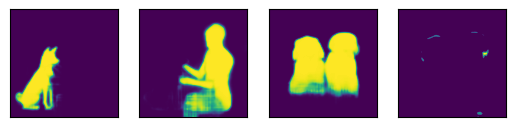

In [ ]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_person_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(image_list))
    for cls in ('dog', 'person')
]

print(weights.meta["categories"]) # what are the categories?
show(dog_and_person_masks)

The [draw_segmentation_masks](https://pytorch.org/vision/main/generated/torchvision.utils.draw_segmentation_masks.html) function can be used to plots those masks on top of the original image. This function expects the masks to be boolean masks, but our masks above contain probabilities in ``[0, 1]``. To get boolean masks, the outputs have to be thresholded

shape = torch.Size([2, 600, 600]), dtype = torch.bool


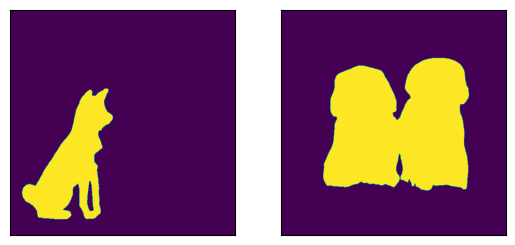

In [ ]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

``boolean_dog_masks``  create a mask for which pixels 'dog' is the most likely class prediction.

Now that we have boolean masks, we can use them with [torchvision.utils.draw_segmentation_masks](https://pytorch.org/vision/main/generated/torchvision.utils.draw_segmentation_masks.html) to plot them on top of the original images:

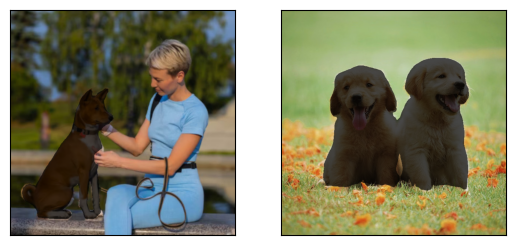

In [ ]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(image_list, boolean_dog_masks)
]
show(dogs_with_masks)

We can plot more than one mask per image! Remember that the model returned as
many masks as there are classes. Let's ask the same query as above, but this
time for *all* classes, not just the dog class: "For each pixel and each class
C, is class C the most likely class?"

This one is a bit more involved, so we'll first show how to do it with a
single image, and then we'll generalize to the batch



dog1_masks shape = torch.Size([21, 600, 600]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 600, 600]), dtype = torch.bool
torch.Size([21, 600, 600])


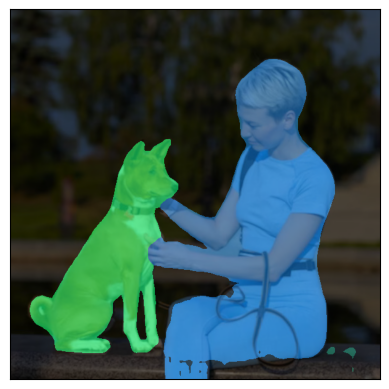

In [ ]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

print(dog1_all_classes_masks.shape)

### Semantic segmentation loss function

tensor(176.9114, grad_fn=<DivBackward1>)


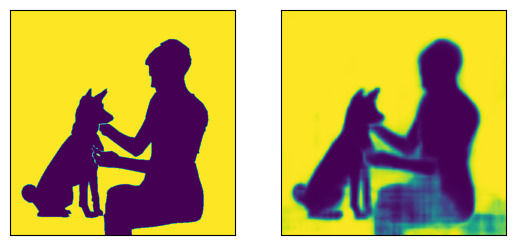

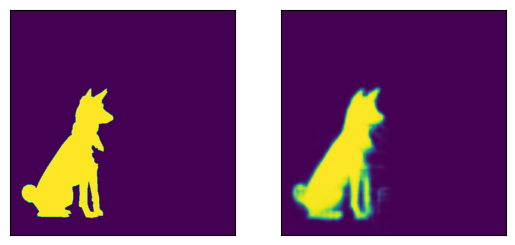

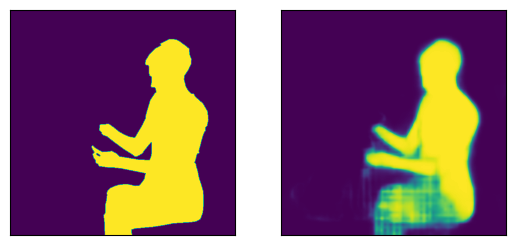

In [ ]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

# What loss function can be used for semantic segmentation?
from torch import nn
loss_fn = nn.CrossEntropyLoss()

background = torch.zeros_like(manual_annotation_dog[1])
ground_truth = torch.zeros_like(output)
ground_truth[0][0] = ~((manual_annotation_dog[1]>125) + (manual_annotation_human[1]>125)) # background (note the ~ for negation)
ground_truth[0][12] = (manual_annotation_dog[1]>125) # dog
ground_truth[0][15] = (manual_annotation_human[1]>125) # person

show([ground_truth[0][0].float(), normalized_masks[0][0]])
show([ground_truth[0][12].float(), normalized_masks[0][12]])
show([ground_truth[0][15].float(), normalized_masks[0][15]])

# Compute the loss
loss = loss_fn(normalized_masks[0], ground_truth[0].float())
print(loss)

# Run the backpropagation
#loss.backward()


## Keypoints extractions
The [torchvision.utils.draw_keypoints](https://pytorch.org/vision/main/generated/torchvision.utils.draw_keypoints.html) function can be used to
draw keypoints on images. We will see how to use it with
torchvision's KeypointRCNN loaded with [torchvision.models.detection.keypointrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.keypointrcnn_resnet50_fpn.html).
We will first have a look at output of the model.




In [ ]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image

person_int = read_image("Data_DL/data/humans/man_4.jpg")

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()
model = model.to('cuda:0')

outputs = model([person_float.to('cuda:0')])
print(outputs)

[{'boxes': tensor([[215.5026,  32.4014, 363.4721, 475.1832],
        [360.5880,  20.1245, 494.4651, 489.5873],
        [457.2841,  26.3863, 595.3298, 509.4178],
        [721.4688,  98.7298, 770.8825, 246.2173],
        [216.7391, 147.2627, 257.5979, 353.3176]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9997, 0.9997, 0.9949, 0.0882], device='cuda:0',
       grad_fn=<IndexBackward0>), 'keypoints': tensor([[[266.0052,  75.9062,   1.0000],
         [273.7254,  66.2385,   1.0000],
         [260.2151,  70.1056,   1.0000],
         [295.5992,  63.6604,   1.0000],
         [255.0684,  72.0391,   1.0000],
         [323.9064, 119.0887,   1.0000],
         [254.4250, 117.7997,   1.0000],
         [347.0668, 190.6299,   1.0000],
         [229.9779, 182.2512,   1.0000],
         [347.7101, 254.4368,   1.0000],
         [244.7749, 137.1351,   1.0000],
         [304.6060, 253.7923,   1.0000],
         [255.7117, 

In [ ]:
outputs = model([person_float.to('cuda:0')])

As we see the output contains a list of dictionaries.
The output list is of length batch_size.
We currently have just a single image so length of list is 1.
Each entry in the list corresponds to an input image,
and it is a dict with keys `boxes`, `labels`, `scores`, `keypoints` and `keypoint_scores`.
Each value associated to those keys has `num_instances` elements in it.
In our case above there are multiple instances detected in the image.



In [ ]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[266.0052,  75.9062,   1.0000],
         [273.7254,  66.2385,   1.0000],
         [260.2151,  70.1056,   1.0000],
         [295.5992,  63.6604,   1.0000],
         [255.0684,  72.0391,   1.0000],
         [323.9064, 119.0887,   1.0000],
         [254.4250, 117.7997,   1.0000],
         [347.0668, 190.6299,   1.0000],
         [229.9779, 182.2512,   1.0000],
         [347.7101, 254.4368,   1.0000],
         [244.7749, 137.1351,   1.0000],
         [304.6060, 253.7923,   1.0000],
         [255.7117, 253.1478,   1.0000],
         [289.8091, 340.8018,   1.0000],
         [270.5087, 351.7586,   1.0000],
         [311.0394, 441.3462,   1.0000],
         [289.1657, 444.5688,   1.0000]],

        [[418.1938,  61.7184,   1.0000],
         [427.2048,  52.6903,   1.0000],
         [415.6192,  53.3351,   1.0000],
         [454.2377,  61.0735,   1.0000],
         [413.6883,  61.0735,   1.0000],
         [485.1324, 112.0180,   1.0000],
         [411.1138, 110.7282,   1.0000],
         [488.

The KeypointRCNN model detects there are two instances in the image.
We could now set a threshold confidence and plot instances which we are confident enough.
Let us set a threshold of 0.75 and filter out the keypoints corresponding to the person.

In [ ]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[266.0052,  75.9062,   1.0000],
         [273.7254,  66.2385,   1.0000],
         [260.2151,  70.1056,   1.0000],
         [295.5992,  63.6604,   1.0000],
         [255.0684,  72.0391,   1.0000],
         [323.9064, 119.0887,   1.0000],
         [254.4250, 117.7997,   1.0000],
         [347.0668, 190.6299,   1.0000],
         [229.9779, 182.2512,   1.0000],
         [347.7101, 254.4368,   1.0000],
         [244.7749, 137.1351,   1.0000],
         [304.6060, 253.7923,   1.0000],
         [255.7117, 253.1478,   1.0000],
         [289.8091, 340.8018,   1.0000],
         [270.5087, 351.7586,   1.0000],
         [311.0394, 441.3462,   1.0000],
         [289.1657, 444.5688,   1.0000]],

        [[418.1938,  61.7184,   1.0000],
         [427.2048,  52.6903,   1.0000],
         [415.6192,  53.3351,   1.0000],
         [454.2377,  61.0735,   1.0000],
         [413.6883,  61.0735,   1.0000],
         [485.1324, 112.0180,   1.0000],
         [411.1138, 110.7282,   1.0000],
         [488.

Great, now we have the keypoints corresponding to the person.
Each keypoint is represented by x, y coordinates and the visibility.
We can now use the [draw_keypoints](https://pytorch.org/vision/main/generated/torchvision.utils.draw_keypoints.html) function to draw keypoints.


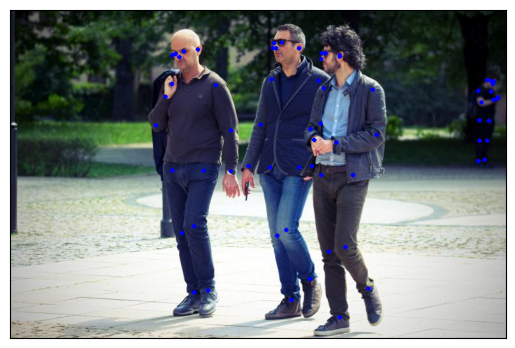

In [ ]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(person_int, keypoints, colors="blue", radius=3)
show(res)

As we see the keypoints appear as colored circles over the image.
The coco keypoints for a person are ordered and represent the following list.\



In [ ]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

What if we are interested in joining the keypoints?
This is especially useful in creating pose detection or action recognition.
We can join the keypoints easily using the `connectivity` parameter.
A close observation would reveal that we would need to join the points in below
order to construct human skeleton.

nose -> left_eye -> left_ear.                              (0, 1), (1, 3)

nose -> right_eye -> right_ear.                            (0, 2), (2, 4)

nose -> left_shoulder -> left_elbow -> left_wrist.         (0, 5), (5, 7), (7, 9)

nose -> right_shoulder -> right_elbow -> right_wrist.      (0, 6), (6, 8), (8, 10)

left_shoulder -> left_hip -> left_knee -> left_ankle.      (5, 11), (11, 13), (13, 15)

right_shoulder -> right_hip -> right_knee -> right_ankle.  (6, 12), (12, 14), (14, 16)

We will create a list containing these keypoint ids to be connected.



In [ ]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

We pass the above list to the connectivity parameter to connect the keypoints.




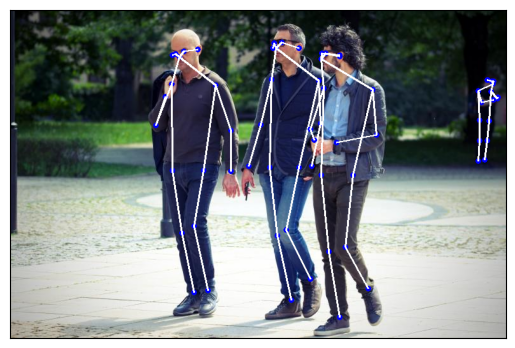

In [ ]:
res = draw_keypoints(person_int, keypoints, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)